In [1]:
import numpy as np
import rasterio
from rasterio.plot import show, show_hist
import glob
from scipy.spatial import cKDTree

In [2]:
def getMeanWindow(raster_list):
    '''
    Function that calculates the mean value of a raster(s) within a moving window. 
    Accepts a list of rasters, removes values less than zero, moves a window of 11x9 across an array,
    calculates the mean within the window, and assigns the values to an output array.
    '''
    output_arrays = []
    for raster in raster_list:
        with rasterio.open(raster) as data:
            array = data.read(1)
            array = np.where(array < 0, 0, array)
            mean_array = np.zeros_like(array)
            for row in range(5, array.shape[0] - 5):
                for col in range(4, array.shape[1] - 4):
                    window = array[row: row + 11, col: col + 9]
                    mean_array[row, col] = window.mean()
            output_arrays.append(mean_array)
    return(output_arrays)

In [3]:
in_data_dir = r'C:\Users\delaney\Desktop\geog5092_workspace\lab4\data'
out_data_dir = r'C:\Users\delaney\Desktop\geog5092_workspace\lab4\output_data'

tifs = glob.glob(in_data_dir + r'\*.tif')
remove1 = tifs.pop(1)
remove2 = tifs.pop(2)

tifs

['C:\\Users\\delaney\\Desktop\\geog5092_workspace\\lab4\\data\\protected_areas.tif',
 'C:\\Users\\delaney\\Desktop\\geog5092_workspace\\lab4\\data\\slope.tif',
 'C:\\Users\\delaney\\Desktop\\geog5092_workspace\\lab4\\data\\urban_areas.tif',
 'C:\\Users\\delaney\\Desktop\\geog5092_workspace\\lab4\\data\\water_bodies.tif',
 'C:\\Users\\delaney\\Desktop\\geog5092_workspace\\lab4\\data\\ws80m.tif']

In [4]:
output_arrays = getMeanWindow(tifs)

In [5]:
#evaluate each of the criteria to produce 5 seperate Boolean arrays

wild_boolean = np.where(output_arrays[0] < 0.05, 1, 0)
slope_boolean = np.where(output_arrays[1] < 15, 1, 0)
urban_boolean = np.where(output_arrays[2] == 1, 0, 1)
water_boolean = np.where(output_arrays[3] < 0.02, 1, 0)
wind_boolean = np.where(output_arrays[4] > 8.5, 1, 0)

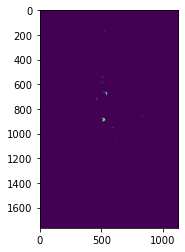

<AxesSubplot:>

In [6]:
#sum the booleans for suitable sites

sum_boolean = wild_boolean + slope_boolean + urban_boolean + water_boolean + wind_boolean
suitable_sites = np.where(sum_boolean == 5, 1, 0)

show(suitable_sites)

In [7]:
#convert to a geotiff raster

sample_tif = rasterio.open(tifs[0])

with rasterio.open(out_data_dir + r'\suitable_sites.tif', 'w',
                   driver = 'GTiff',
                   height = suitable_sites.shape[0],
                   width = suitable_sites.shape[1],
                   count = 1,
                   dtype = 'int8',
                   transform = sample_tif.transform,
                   crs = sample_tif.crs,
                   nodata = sample_tif.nodata
) as out_raster:
    suitable_sites = suitable_sites.astype('int8')
    out_raster.write(suitable_sites, indexes = 1)

In [8]:
#final print statement for part 1:

print('There are', suitable_sites.sum(), 'suitable sites for a wind farm according to the specified criteria.')

There are 753 suitable sites for a wind farm according to the specified criteria.


In [9]:
#extracting transmission station coordinate pairs

with open(in_data_dir + r'\transmission_stations.txt') as fhand:
    station_coords = []
    txt_list = [line.rstrip() for line in fhand]
    for item in txt_list[1:]:
        item = item.split(',')
        station_coords.append((float(item[0]), float(item[1])))
    
    stations_array = np.array(station_coords)

In [10]:
#creating centroid points for suitable sites and performing nearest neighbor

with rasterio.open(out_data_dir + r'\suitable_sites.tif') as suitable_sites:
    cell_size = suitable_sites.transform[0]
    extent = suitable_sites.bounds

    center_x = np.arange(extent[0] + cell_size / 2, extent[2], cell_size)
    center_y = np.arange(extent[1] + cell_size / 2, extent[3], cell_size)

    x,y = np.meshgrid(center_x, center_y)
    centroids = np.c_[x.flatten(), y.flatten()]

    dist, indexes = cKDTree(stations_array).query(centroids)

In [12]:
#final print statement for part 2:

print('Shortest distance from a suitable site to a transmission station =', round(dist.max(), 2), 'meters')
print('Longest distance from a suitable site to a transmission station =', round(dist.min(), 2), 'meters')

Shortest distance from a suitable site to a transmission station = 659876.95 meters
Longest distance from a suitable site to a transmission station = 13.4 meters
